In [1]:
# Импорт библиотек
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Чтение файла
lollipops = pd.read_csv('Леденцы.dat', sep=';')

# Небольшой разведочный анализ
print("Первые 5 строк датафрейма:")
display(lollipops.head())
print(f"\nРазмер датафрейма: {lollipops.shape}")
print("\nОсновная информация:")
lollipops.info()
print("\nОписательная статистика:")
display(lollipops.describe())
print("\nПропущенные значения:", lollipops.isnull().sum(), sep='\n')

Первые 5 строк датафрейма:


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11
0,4,5,5,5,3,3,3,3,3,3,3
1,5,4,5,5,3,3,3,3,3,3,3
2,5,5,4,5,3,3,3,3,3,3,3
3,5,4,5,5,3,3,3,3,3,3,3
4,4,5,5,5,3,3,3,3,3,3,3



Размер датафрейма: (338, 11)

Основная информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 338 entries, 0 to 337
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   V1      338 non-null    int64
 1   V2      338 non-null    int64
 2   V3      338 non-null    int64
 3   V4      338 non-null    int64
 4   V5      338 non-null    int64
 5   V6      338 non-null    int64
 6   V7      338 non-null    int64
 7   V8      338 non-null    int64
 8   V9      338 non-null    int64
 9   V10     338 non-null    int64
 10  V11     338 non-null    int64
dtypes: int64(11)
memory usage: 29.2 KB

Описательная статистика:


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11
count,338.000000,338.000000,338.000000,338.000000,338.000000,338.000000,338.000000,338.000000,338.000000,338.000000,338.000000
mean,3.544379,3.526627,3.517751,3.411243,3.207101,3.204142,3.254438,3.289941,3.603550,3.550296,3.565089
std,0.955748,0.956410,0.990150,0.992311,0.867314,0.869725,0.844107,0.821784,0.969682,0.927082,0.942042
min,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
25%,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000
50%,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000
75%,5.000000,5.000000,5.000000,4.000000,3.000000,3.000000,3.000000,3.000000,5.000000,5.000000,5.000000
max,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000



Пропущенные значения:
V1     0
V2     0
V3     0
V4     0
V5     0
V6     0
V7     0
V8     0
V9     0
V10    0
V11    0
dtype: int64


In [3]:
# Стандартизируем данные
scaler = StandardScaler()
lollipops_scaled = scaler.fit_transform(lollipops)

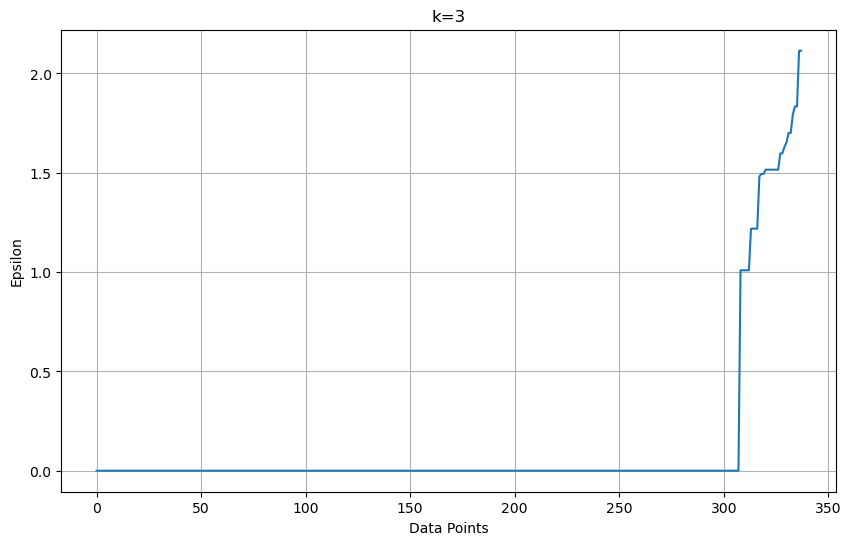

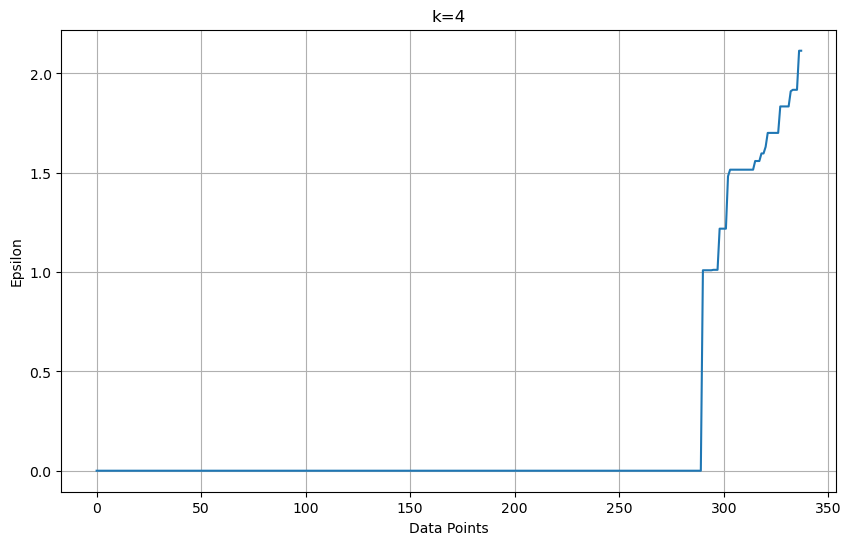

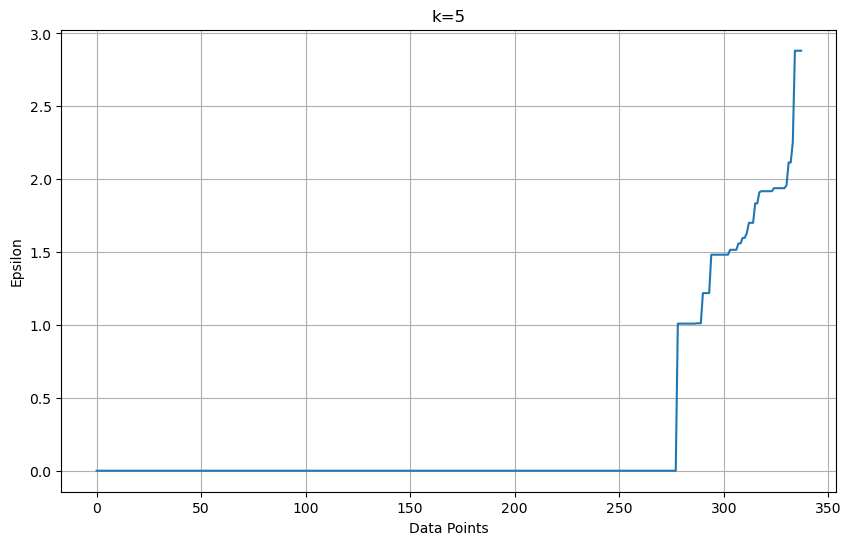

In [4]:
# Метод локтя для подбора eps
def find_optimal_eps(X, k):
    neighbors = NearestNeighbors(n_neighbors=k)
    neighbors_fit = neighbors.fit(X)
    distances, indices = neighbors_fit.kneighbors(X)
    distances = np.sort(distances[:, k-1], axis=0)
    
    plt.figure(figsize=(10, 6))
    plt.plot(distances)
    plt.title(f'k={k}')
    plt.xlabel('Data Points')
    plt.ylabel('Epsilon')
    plt.grid(True)
    plt.show()
    
    return distances

# Смотрим график для различных k=min_samples
for k in [3, 4, 5]:
    distances = find_optimal_eps(lollipops_scaled, k)

Из графиков выше видно, что оптимальное для различных k eps ~ 1.01.
При этом для различных k разная "длина локтя". Интерпретация:  
k=3 (маленький локоть) - более чувствительный, находит более редкие кластеры, 
при этом может создать много кластеров и шума.  
k=5 (бо'льший локоть) - более консервативный, находит более плотные кластеры, при этом при дальнейшем увеличении k есть риск объединить все кластеры в один.  
k=4 - золотая середина

In [11]:
# Считаем количество кластеров для k=4 и eps = 1.01
print("Для eps=1.01:")

dbscan = DBSCAN(eps=1.01, min_samples=4)
clusters = dbscan.fit_predict(lollipops_scaled)
    
n_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)
        
print(f"min_samples=4: {n_clusters} кластеров")
    


Для eps=1.01:
min_samples=4: 15 кластеров


Количество кластеров, ранвое 15 говорит и чрезмерной фрагментации данных, что может затруднить смысловую интерпретацию данных и дальнейшее применение результатов анализа. Давайте попробуем сократить число кластеров до какого-то разумного количества (при этом помня, что иерархический анализ и метод k-средних выделили по 4 кластера)

In [12]:
# Тестируем бо'льшие значения eps
for k in [4]:
    for eps in [1.5, 2.0, 2.5, 3.0]:
        dbscan = DBSCAN(eps=eps, min_samples=k)
        clusters = dbscan.fit_predict(lollipops_scaled)
        
        n_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)
                
        print(f"k={k}, eps={eps}: {n_clusters:2d} кластеров", sep = "\n")

       

k=4, eps=1.5:  9 кластеров
k=4, eps=2.0:  5 кластеров
k=4, eps=2.5:  4 кластеров
k=4, eps=3.0:  2 кластеров


Теперь количество кластеров от 2 до 9, уже лучше. Но надо выбрать лучшую пару значений. Проанализируем все пары: посчитаем их шумы, размеры кластеров, силуэтный коэффициент (чем ближе к 1, тем лучше).

In [35]:
from sklearn.metrics import silhouette_score

candidates = [
    {'k': 4, 'eps': 1.5},
    {'k': 4, 'eps': 2.0},
    {'k': 4, 'eps': 2.5},
    {'k': 4, 'eps': 3.0}
]

for candidate in candidates:
    dbscan = DBSCAN(eps=candidate['eps'], min_samples=candidate['k'])
    clusters = dbscan.fit_predict(lollipops_scaled)
    
    n_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)
    n_noise = list(clusters).count(-1)
    noise_percentage = (n_noise / len(clusters)) * 100
    
    # Оцениваем качество кластеров
    non_noise_mask = clusters != -1
    if len(set(clusters[non_noise_mask])) > 1:
        silhouette = silhouette_score(lollipops_scaled[non_noise_mask], clusters[non_noise_mask])
    else:
        silhouette = -1
    
    print(f"k={candidate['k']}, eps={candidate['eps']}:")
    print(f"  - Кластеров: {n_clusters}")
    print(f"  - Шум: {n_noise} точек ({noise_percentage:.1f}%)")
    print(f"  - Silhouette score: {silhouette:.3f}")
    
    # Считаем размеры кластеров
    cluster_sizes = []
    for cluster_id in set(clusters):
        if cluster_id != -1:
            size = list(clusters).count(cluster_id)
            cluster_sizes.append(size)
    
    print(f"  - Размеры кластеров: {cluster_sizes}")
    print(f"  - Баланс кластеров: min={min(cluster_sizes)}, max={max(cluster_sizes)}")
    print()

k=4, eps=1.5:
  - Кластеров: 9
  - Шум: 33 точек (9.8%)
  - Silhouette score: 0.855
  - Размеры кластеров: [101, 59, 15, 10, 7, 37, 15, 9, 52]
  - Баланс кластеров: min=7, max=101

k=4, eps=2.0:
  - Кластеров: 5
  - Шум: 2 точек (0.6%)
  - Silhouette score: 0.679
  - Размеры кластеров: [110, 104, 4, 61, 57]
  - Баланс кластеров: min=4, max=110

k=4, eps=2.5:
  - Кластеров: 4
  - Шум: 0 точек (0.0%)
  - Silhouette score: 0.543
  - Размеры кластеров: [110, 104, 4, 120]
  - Баланс кластеров: min=4, max=120

k=4, eps=3.0:
  - Кластеров: 2
  - Шум: 0 точек (0.0%)
  - Silhouette score: 0.447
  - Размеры кластеров: [230, 108]
  - Баланс кластеров: min=108, max=230



Проанализировав 4 пары значений видим следующее:  
При eps = 1.5 большое количество шума  
При eps = 2.5 получились кластеры как при методах иерарического анализа и kmeans (и отсутствие шума)  
При eps = 3.0 получилась самое маленькое значение силуэтного коэффициента  
При eps = 2.5 получили кластеры близкие к предыдущим двум методам, но также обнаружили два шума. Проанализируем их

In [36]:
# Выбираем параметры с шумом
dbscan = DBSCAN(eps=2.0, min_samples=4)
clusters = dbscan.fit_predict(lollipops_scaled)
lollipops['cluster'] = clusters

# Берём шумовые точки
noise_points = lollipops[lollipops['cluster'] == -1]
print(f"Найдено шумовых точек: {len(noise_points)}")
print("\nШумовые точки:")
display(noise_points)

print("Анализ профилей шумовых точек:")
print("=" * 50)

# Сравниваем со средними по всему датасету
print("Средние значения по всему датасету:")
display(lollipops[['V1','V2','V3','V4','V5','V6','V7','V8','V9','V10','V11']].mean())

for i, (idx, row) in enumerate(noise_points.iterrows()):
    print(f"\nШумовая точка #{i+1} (индекс {idx}):")
    print("Ответы:", row[['V1','V2','V3','V4','V5','V6','V7','V8','V9','V10','V11']].values)
    
    # Находим аномальные значения (сильно отличающиеся от среднего)
    means = lollipops[['V1','V2','V3','V4','V5','V6','V7','V8','V9','V10','V11']].mean()
    anomalies = []
    for col in ['V1','V2','V3','V4','V5','V6','V7','V8','V9','V10','V11']:
        if abs(row[col] - means[col]) > 2:  # эмпирически взяла двойку, значение можно поменять
            anomalies.append(f"{col}={row[col]} (среднее={means[col]:.1f})")
    
    if anomalies:
        print("Аномальные значения:", ", ".join(anomalies))
    else:
        print("Нет явных аномалий - возможно, уникальная комбинация ответов")

Найдено шумовых точек: 2

Шумовые точки:


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,cluster
308,3,2,2,2,2,3,5,5,3,3,3,-1
324,3,2,2,2,2,3,5,5,3,3,3,-1


Анализ профилей шумовых точек:
Средние значения по всему датасету:


V1     3.544379
V2     3.526627
V3     3.517751
V4     3.411243
V5     3.207101
V6     3.204142
V7     3.254438
V8     3.289941
V9     3.603550
V10    3.550296
V11    3.565089
dtype: float64


Шумовая точка #1 (индекс 308):
Ответы: [3 2 2 2 2 3 5 5 3 3 3]
Нет явных аномалий - возможно, уникальная комбинация ответов

Шумовая точка #2 (индекс 324):
Ответы: [3 2 2 2 2 3 5 5 3 3 3]
Нет явных аномалий - возможно, уникальная комбинация ответов


Проанализировали, поняли, что шумы - просто уникальная комбинация ответов, это не какие-то экстравыпадающие значения типа -99999, которые исказили бы нам данные, а просто редкоче сочетание причин, по которой люди едят леденцы. Теперь оставшиеся точки (не шумовые) надо как-то разбить по кластерам. Для этого удобно визуализировать наши данные любым удобным способом.

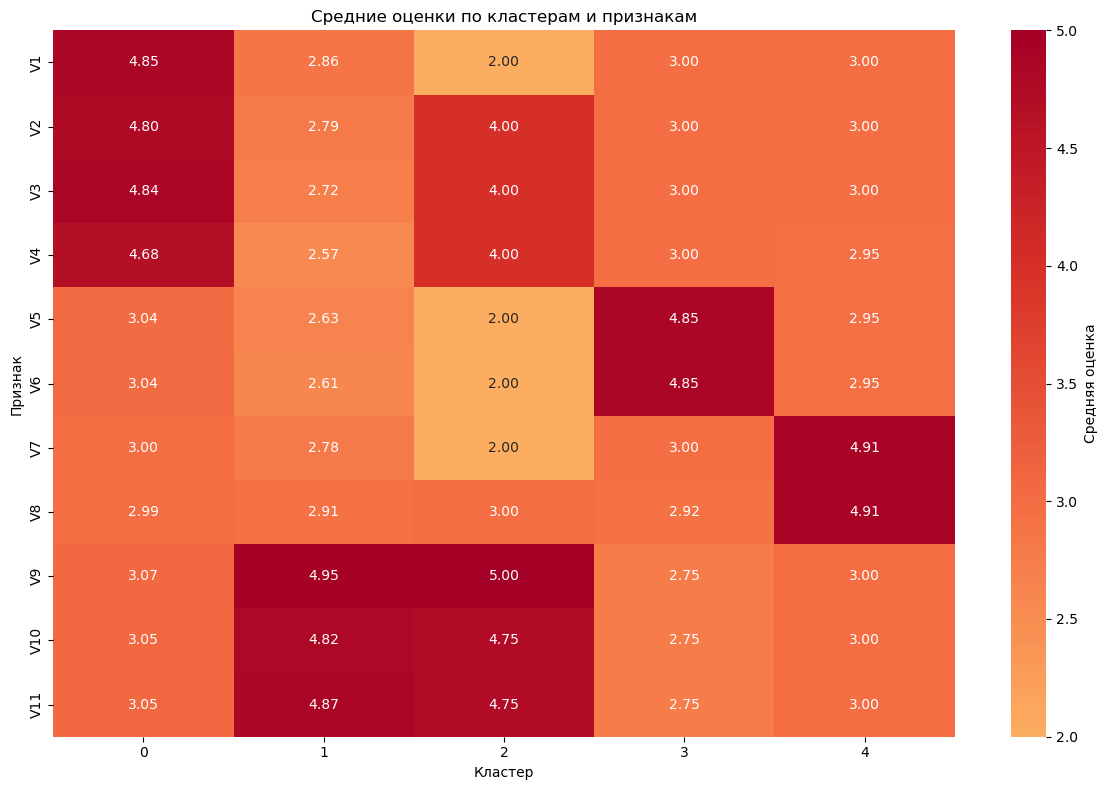

In [32]:
# Один из вариантов визуализации кластеров - тепловая карта со средними значениями по каждому высказыванию
cluster_means = lollipops[lollipops['cluster'] != -1].groupby('cluster')[V_columns].mean()

plt.figure(figsize=(12, 8))
sns.heatmap(cluster_means.T, 
            annot=True, 
            cmap='RdYlBu_r', 
            center=0,
            fmt='.2f',
            cbar_kws={'label': 'Средняя оценка'})
plt.title('Средние оценки по кластерам и признакам')
plt.xlabel('Кластер')
plt.ylabel('Признак')
plt.tight_layout()
plt.show()

Кластеры по методу DBSCAN:  
Кластер 0: "Я потребляю леденцы для свежести дыхания и уверенности"  
Кластер 1: "Я потребляю леденцы по состоянию здоровья"  
Кластер 2: "Я потребляю леденцы по состоянию здоровья полости рта"  
Кластер 3: "Я потребляю леденцы, потому что хочу сладкое"  
Кластер 4: "Я потребляю леденцы для концентрации"  

**ОБЩИЕ ВЫВОДЫ ПО ТРЁМ ЛАБОРАТОРНЫМ РАБОТАМ** 

В рамках выполнения 1-3 лабораторных работ были применены три типа кластерного анализа:  
- Иерархический
- Методом к-средних
- Методом DBSCAN.

Иерархический анализ и анализ методом k-средних дали абсолютно идентичные результаты, что даёт уверенность в правдоподобности полученных кластеров.

Метод DBSCAN выявил две шумовые точки - изолированные точки, не подходящие ни для какого кластера. Проанализировав данные в этих точках, стало ясно, что эти респонденты просто имеют уникальное сочетание мотивов потребления леденцов, не подходящие ни под один кластер.  

При этом общее число кластеров методом DBSCAN получилось равным 5, что на 1 больше, чем другими методами. И на тепловой карте видно, какие данные отделились от какого кластера: ранее был кластер "Я потребляю леденцы по состоянию здоровья", теперь добавился ещё один кластер, связанный со здоровьем, но уже исключительно полости рта (а не больного горла или заложенности носа, например).  

Подбор метода классификации - процесс, индивидуальный для каждого датасета и нет однозначного ответа на вопрос, какой же кластерный анализ использовать в каждом случае. Однако можно опираться на следующее:    
- Иерархический аналих отличный инструмент для визуализации кластеров в виде дендрограммы и его важное отличие от, например, метода k-средних - то, что нет необходимости знать количество кластеров заранее. Однако иногда дендрограммы недостаточно, и в случае сомнений при определении числа кластеров можно дополнительно построить график каменистая осыпь.  
- Метод k-средних стоит применять с осторожностью, так как он подразумевает человеческий фактор: применяющий этот метод человек должен заранее определить примерное количество кластеров.  
- Метод DBSCAN хорош тем, дополнительно обрабатывает выбросы, не пытаясь включить их в какой-либо кластер, а удаля их из набора данных. При этом метод сложен тем, что необходимо подбирать оптимальный радиус окрестности и минимальное количество соседей - точек данных, входящих в эту окрестность.  